https://ga-dev-tools.appspot.com/dimensions-metrics-explorer/#ga:referralPath


## All imports 

In [105]:
#only palakh
import os
os.chdir("D:/Palakh Data/Desktop/apm_group_project_fall19-master/Notebooks and Data")
print(os.getcwd())

D:\Palakh Data\Desktop\apm_group_project_fall19-master\Notebooks and Data


In [106]:
#imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn import preprocessing
import numpy as np
import argparse
from apiclient.discovery import build
import httplib2
from oauth2client import client
from oauth2client import file
from oauth2client import tools
from pandas.tseries.holiday import Holiday,AbstractHolidayCalendar
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from fbprophet import Prophet
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

# !pip install pmdarima
from pmdarima.arima import auto_arima
# !pip install plotly 
import plotly
import plotly.graph_objs as go
from plotly.offline import *
import statsmodels.api as sm
import datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# New Users Data Pull

Date        0
newUsers    0
users       0
dtype: int64


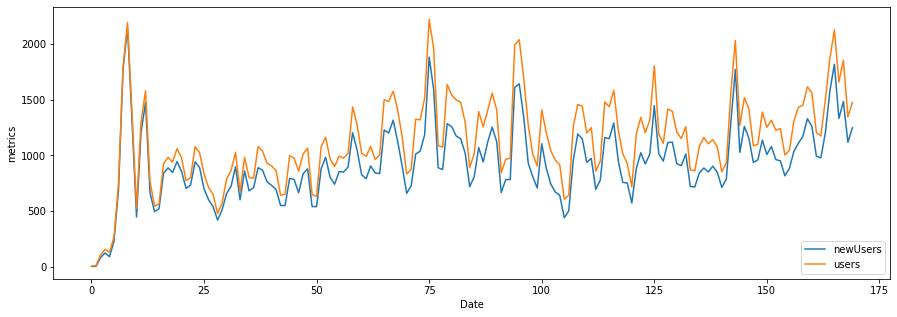

In [107]:
# ---------User count data
start_date='2019-06-01'
end_date= '2019-11-17'
metrics='ga:newUsers,ga:users'
dimensions='ga:Date'

# ---------get results
results = get_results(service, profile,start_date,end_date,metrics,dimensions)
df = get_df(results,metrics,dimensions)
df[:10]

met = ['newUsers','users']
get_trend(df,met)

print (df.isnull().sum())
df_newuser = df[['Date','newUsers']]
df_alluser = df[['Date','users']]
df_newuser.index = pd.DatetimeIndex(df_newuser.Date, freq='D')
df_alluser.index = pd.DatetimeIndex(df_alluser.Date, freq='D')
df_newuser.drop(columns='Date',axis=1,inplace=True)
df_alluser.drop(columns='Date',axis=1,inplace=True)

# Exogenous Variable Creation Date Wise 

In [108]:

start_date='2019-06-01'
end_date= '2019-11-17'

days = pd.date_range(start_date, end_date, freq='D')
days = pd.DataFrame({'Date':days})
days.set_index('Date',inplace=True)

data = days
data['month'] = data.index.month
data['day'] = data.index.day
data['weekday'] = data.index.weekday
cal = calendar()
holidays = cal.holidays(start=data.index.min(), end = data.index.max())
data['is_holiday'] = data.index.isin(holidays)
data['is_holiday'] = data['is_holiday'].astype(int)
data['is_weekend'] = data['weekday'].map(is_weekend)
data['is_weekday'] = np.where(data['is_weekend']==0,1,0)
data['holiday_weekday'] = np.where((data['is_weekday']==1)&(data['is_holiday']==1),1,0)
data['holiday_weekend'] = np.where((data['is_weekend']==1)&(data['is_holiday']==1),1,0)
data['inbetween25and5'] = np.where((data['day']>=25)|(data['day']<=5),1,0)
days = data.asfreq('D')
days[:5]

,month,day,weekday,is_holiday,is_weekend,is_weekday,holiday_weekday,holiday_weekend,inbetween25and5
Date,,,,,,,,,
2019-06-01,6,1,5,0,1,0,0,0,1
2019-06-02,6,2,6,0,1,0,0,0,1
2019-06-03,6,3,0,0,0,1,0,0,1
2019-06-04,6,4,1,0,0,1,0,0,1
2019-06-05,6,5,2,0,0,1,0,0,1


# 1. Confirmed Users 
# 2. Merge Confirmed users with Exogenous Variables

Sign Up               170
Next Step             165
Continue              163
Contact Us            161
Confirm Enrollment    151
Brokers                51
Businesses             28
My Account             11
continue               10
(not set)               4
Name: eventLabel, dtype: int64
76
0


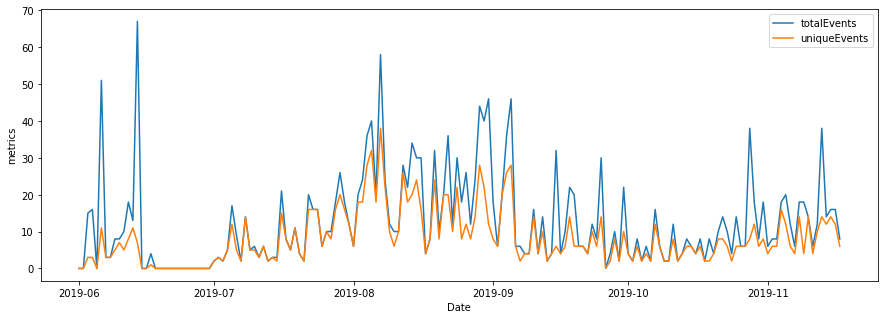

In [109]:
# ---------signup data
start_date='2019-06-01'
end_date= '2019-11-17'
metrics='ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent'
dimensions='ga:Date,ga:eventLabel'

# ---------get results
results = get_results(service, profile,start_date,end_date,metrics,dimensions)
df = get_df(results,metrics,dimensions)
print (df['eventLabel'].value_counts())

# ---------filtering for 'sign up' event
df1 = df[(df['eventLabel']=='Confirm Enrollment')]
aggregation = {'uniqueEvents':sum,'totalEvents':sum,'sessionsWithEvent':sum,'eventsPerSessionWithEvent':sum}        
df2 = df1.groupby('Date').agg(aggregation)
df2.reset_index(inplace=True)
df2.set_index('Date',inplace=True)

# signup of days with confirmed users
df_signup = days.join(df2,on='Date',how='left')

print (df_signup.isnull().sum().sum())
df_signup = df_signup.fillna(0)
print (df_signup.isnull().sum().sum())
df_signup[:10]


met = ['totalEvents','uniqueEvents']#['uniqueEvents','totalEvents','sessionsWithEvent'] 
get_trend(df_signup,met)

# Final merging data with new users

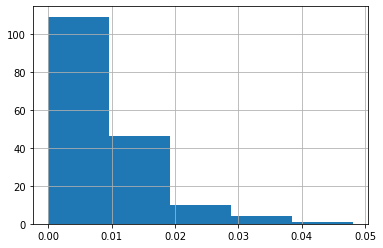

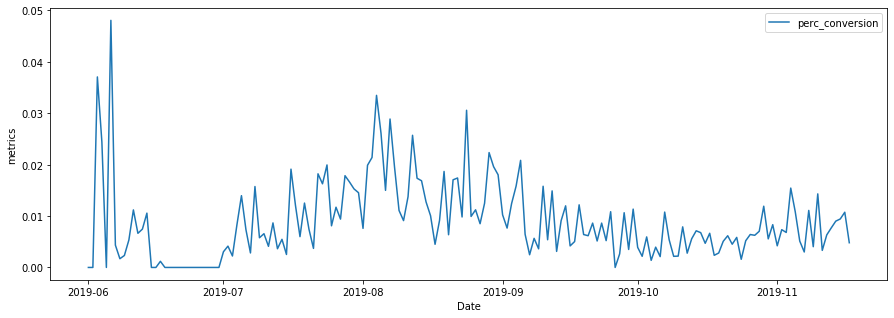

In [118]:
# --total signup preprocessing
# df_total_signup = df_signup[[uniqueEvents']]
# df_total_signup = df_total_signup.loc[(df_total_signup.Date > '2019-06-30')&(df_total_signup.Date <= '2019-11-17')]
# df_total_signup.index = pd.DatetimeIndex(df_total_signup.Date, freq='D')
# df_total_signup.drop(columns='Date',axis=1,inplace=True)
# df_unique_signup = df_signup[['uniqueEvents']].rename(columns={'uniqueEvents':'signups'},inplace=True)
# print df_unique_signup.index

# --newusers and signups and exogenous variables
df_prec_signup = df_newuser.join(df_signup, on='Date',how='inner')
#df_prec_signup = days.join(df_prec_signup, on='Date',how='left')

df_prec_signup['perc_conversion'] = df_prec_signup['uniqueEvents']/df_prec_signup['newUsers']*1
df_prec_signup.rename(columns={'uniqueEvents':'signups'},inplace=True)
# print (df.isnull().sum())
# --0
# print (df_prec_signup.index)
# --DatetimeIndex

df_prec_signup['perc_conversion'].hist(bins=5)
df_prec_signup.describe()

met = ['perc_conversion']
get_trend(df_prec_signup,met)

In [119]:
# Final pre-processed data 
df_prec_signup

,newUsers,month,day,weekday,is_holiday,is_weekend,is_weekday,holiday_weekday,holiday_weekend,inbetween25and5,signups,totalEvents,sessionsWithEvent,eventsPerSessionWithEvent,perc_conversion
Date,,,,,,,,,,,,,,,
2019-06-01,2.0,6,1,5,0,1,0,0,0,1,0.0,0.0,0.0,0.0,0.000000
2019-06-02,3.0,6,2,6,0,1,0,0,0,1,0.0,0.0,0.0,0.0,0.000000
2019-06-03,81.0,6,3,0,0,0,1,0,0,1,3.0,15.0,0.0,0.0,0.037037
2019-06-04,123.0,6,4,1,0,0,1,0,0,1,3.0,16.0,0.0,0.0,0.024390
2019-06-05,90.0,6,5,2,0,0,1,0,0,1,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-13,1820.0,11,13,2,0,0,1,0,0,0,14.0,38.0,1.0,38.0,0.007692
2019-11-14,1333.0,11,14,3,0,0,1,0,0,0,12.0,14.0,1.0,14.0,0.009002
2019-11-15,1485.0,11,15,4,0,0,1,0,0,0,14.0,16.0,0.0,0.0,0.009428


# S-arima Hyper-Parameter Tuning

In [ ]:
data = dta['totalEvents']#[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# data split
n_test = 30
# model configs
cfg_list = sarima_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('Done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

# Model - Daily Seasonal Arima 

                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           2.0513     11.202      0.183      0.855     -19.905      24.008
is_holiday       -155.9074     33.322     -4.679      0.000    -221.218     -90.597
is_weekend       -142.4795   1.73e+04     -0.008      0.993    -3.4e+04    3.37e+04
is_weekday        142.4815   1.73e+04      0.008      0.993   -3.38e+04    3.41e+04
holiday_weekday  -155.9074     33.323     -4.679      0.000    -221.220     -90.595
holiday_weekend          0     79.801          0      1.000    -156.408     156.408
inbetween25and5    80.7666     76.519      1.056      0.291     -69.209     230.742
ar.L1               0.3193      7.531      0.042      0.966     -14.441      15.079
ar.L2               0.0667      6.207      0.011      0.991     -12.098      12.231
ar.L3              -0.1171      2.588     -0.045      0.964      -5.189     

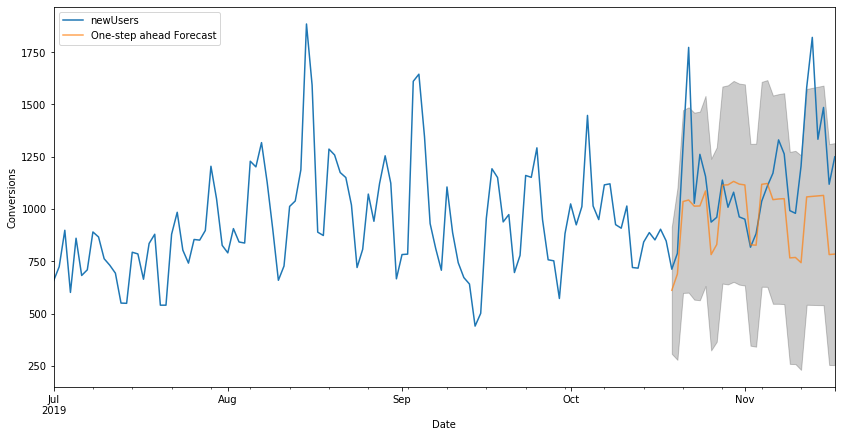

mse: 89443.86796198731
The Mean Squared Error of our forecasts is 89443.87
The Root Mean Squared Error of our forecasts is 299.07


In [120]:
data=df_prec_signup
model_start_date = '2019-06-30'
model_end_date = '2019-11-17'
xvars=['is_holiday','is_weekend','is_weekday',
       'holiday_weekday','holiday_weekend','inbetween25and5']
#       'newUsers','signups']
yvar=['newUsers']
col_order = yvar+xvars
data = data.loc[(data.index > model_start_date)&(data.index <= model_end_date)]
data = data[col_order]

n_test=30
train, test = train_test_split(data, n_test)
config = [(3, 1, 2), (1, 0, 3, 4), 'c']
order, sorder, trend = config

result_daily = my_train_sarimax(train,xvars,yvar,i_order=order, 
                                i_freq='D', i_seasonorder=sorder,
                                trend=trend, print_summary=True)
y_truth, y_forecasted = compare_pred_vs_real(result_daily, data, yvar, '2019-10-19','2019-11-17', exog_validation=data['2019-10-19':'2019-11-17'][xvars])
# y_truth.values - y_forecasted.values



#  User Defined Functions 

In [121]:
def is_weekend(weekday):
    if weekday>4:
        return 1
    else:
        return 0
    
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]


def to_float(s):
    return float(s)

import matplotlib.pyplot as plt

def get_trend(data,metrics):
    '''
    Date column must be names 'Date' for the trend function to work
    '''
    n_met = len(metrics)
    fig, ax = plt.subplots(figsize=(15, 5))
    
    for met in metrics:
        plt.plot(data.index, data[met],label=met)
    plt.xlabel('Date')
    plt.ylabel('metrics')
    plt.legend(loc='best')

def get_resid_plot(actual,pred,norm=True):
    residual = actual-pred
    norm_resid = preprocessing.normalize([residual])
    resid_zero = np.zeros(len(residual))
    if norm:
        residual = norm_resid
    
    a,b = best_fit(pred,residual)
#     print (len(a),len(b))
    yfit = [a + b * xi for xi in pred]
    
    fig, ax = plt.subplots(figsize=(15, 5))
#     plt.plot(pred,resid_zero, color='red', linewidth=1, linestyle= '---')
    ax.scatter(pred, residual, c='black', alpha=0.3, edgecolors='none')
#     plt.plot(pred,yfit, color='grey', linewidth=0.5, linestyle= '--')
    ax.legend()
    ax.grid(False)
    plt.xlabel('pred')
    plt.ylabel('residual')
    plt.legend(loc='best')

def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = 1*sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = 1*sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar
#     print('a,b:',a,b)

#     print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b  

In [122]:
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
# 	print (test.shape, train.shape)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [1,2,3]
	d_params = [1,2]
	q_params = [1,2,3]
	t_params = ['n','c','t','ct']
	P_params = [0,1,2,3]
	D_params = [0,1,2,3]
	Q_params = [0,1,2,3]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models


TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-122-393520532405>, line 106)

In [123]:
def my_train_sarimax(df,xvars,yvar,i_order,i_freq,i_seasonorder,trend,print_summary):
    mod = sm.tsa.statespace.SARIMAX(
                    df[yvar],
                    order=i_order,
                    freq=i_freq,
                    trend=trend,
                    exog=df[xvars],
                    seasonal_order=i_seasonorder,
                    enforce_statioarity=False,
                    enforce_invertibility=False)
    results=mod.fit()
    
    if print_summary:
        print(results.summary().tables[1])
    
    return results

def compare_pred_vs_real(results, df, yvar, predict_from, predict_till, exog_validation = ''):
    pred = results.get_prediction(start=pd.to_datetime(predict_from), end=pd.to_datetime(predict_till), dynamic=False, exog=exog_validation)
    pred_ci = pred.conf_int()

    ax = df[yvar].plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Conversions')
    plt.legend()

    plt.show()
    
    y_forecasted = pred.predicted_mean
    y_truth = df[predict_from:].iloc[:,0]
    
#     y_truth = df[yvar].loc[(df.index >= predict_from)]
#     y_truth = y_truth.astype(np.float)
#     mse_df = pd.concat([y_forecasted,y_truth],axis=1)
#     mse_df.rename(columns={0:'pred'},inplace=True)
#     mse_df.columns[0] = mse_df.columns[0].map(to_float)
#     mse_df.columns[1] = mse_df.columns[1].map(to_float)
#     mse_df['mse'] = mse_df['pred'] - mse_df[yvar]
#     print (mse_df)

    mse = ((y_forecasted - y_truth) ** 2).mean()
    print ('mse:',mse)
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
    
    return y_truth, y_forecasted


# Google Pull

In [115]:
!pip install google-api-python-client
# pip install google-api-python-client
!pip install google-auth-httplib2
!pip install google-auth
!pip install httplib2
!pip install google

# """A simple example of how to access the Google Analytics API."""

def get_service(api_name, api_version, scope, client_secrets_path):
  """Get a service that communicates to a Google API.

  Args:
    api_name: string The name of the api to connect to.
    api_version: string The api version to connect to.
    scope: A list of strings representing the auth scopes to authorize for the
      connection.
    client_secrets_path: string A path to a valid client secrets file.

  Returns:
    A service that is connected to the specified API.
  """
  # Parse command-line arguments.
  parser = argparse.ArgumentParser(
      formatter_class=argparse.RawDescriptionHelpFormatter,
      parents=[tools.argparser])
  flags = parser.parse_args([])

  # Set up a Flow object to be used if we need to authenticate.
  flow = client.flow_from_clientsecrets(
      client_secrets_path, scope=scope,
      message=tools.message_if_missing(client_secrets_path))

  # Prepare credentials, and authorize HTTP object with them.
  # If the credentials don't exist or are invalid run through the native client
  # flow. The Storage object will ensure that if successful the good
  # credentials will get written back to a file.
  storage = file.Storage(api_name + '.dat')
  credentials = storage.get()
  if credentials is None or credentials.invalid:
    credentials = tools.run_flow(flow, storage, flags)
  http = credentials.authorize(http=httplib2.Http())

  # Build the service object.
  service = build(api_name, api_version, http=http)

  return service


def get_first_profile_id(service):
  # Use the Analytics service object to get the first profile id.

  # Get a list of all Google Analytics accounts for the authorized user.
  print (service.management().accounts().list())
  accounts = service.management().accounts().list().execute()


  if accounts.get('items'):
    # Get the first Google Analytics account.
    account = accounts.get('items')[0].get('id')

    # Get a list of all the properties for the first account.
    properties = service.management().webproperties().list(
        accountId=account).execute()

    if properties.get('items'):
      # Get the first property id.
      property = properties.get('items')[0].get('id')

      # Get a list of all views (profiles) for the first property.
      profiles = service.management().profiles().list(
          accountId=account,
          webPropertyId=property).execute()

      if profiles.get('items'):
        # return the first view (profile) id.
        return profiles.get('items')[0].get('id')

  return None


def get_results(service, profile_id,start_date,end_date,metrics,dimensions):#st_dt,end_dt,metrics,dimension
  # Use the Analytics Service Object to query the Core Reporting API
  # for the number of sessions in the past seven days.
  return service.data().ga().get(
      ids='ga:' + '194249459',
      start_date=start_date,
      end_date= end_date,
      metrics=metrics,
      dimensions=dimensions,
      max_results=100000).execute()

def print_results(results):
  # Print data nicely for the user.
  if results:
    print ('View (Profile): %s' % results.get('profileInfo').get('profileName'))

  else:
    print ('No results found')

def get_df(results,metrics,dimensions):
    # --getting results
    df = pd.DataFrame(results.get('rows'))
    
    # --getting col names
    n_dim = len(dimensions.split(','))
    n_met = len(metrics.split(','))
    col = dimensions.split(',')+metrics.split(',')
    col = [i[3:] for i in col] # --removing 'ga:' from col headers
    
    i=0
    for c in col:
        df.rename(columns={i:c},inplace=True)
        if c=='Date':
            df[c]=pd.to_datetime(df[c])
        elif i>(n_dim-1):
            df[c] = df[c].map(to_float)
        i=i+1
    return df

# define scope
scope = ['https://www.googleapis.com/auth/analytics.readonly']

# Authenticate and construct service.
service = get_service('analytics', 'v3', scope, 'client_secret_442504306103-saccqakerkn8epihqmp8ctj2mq1ik08a.apps.googleusercontent.com.json')
profile = get_first_profile_id(service)


# Results

In [ ]:
# data = data['newUsers']#[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
# 	print(data)
# data split
# n_test = 30
# # model configs
# cfg_list = sarima_configs()
# # grid search
# scores = grid_search(data, cfg_list, n_test)
# print('Done')
# # list top 3 configs
# for cfg, error in scores[:3]:
#     print(cfg, error)

# --SARIMA tuning results
# [(3, 1, 2), (0, 0, 2, 0), 't'] 232.47612356928468
# [(1, 2, 1), (0, 0, 1, 0), 'n'] 233.10881976629926
# [(3, 1, 2), (1, 0, 3, 0), 't'] 234.0730493091278


# [(3, 1, 2), (1, 0, 3, 0), 'c'] 222.31529641180092
# [(3, 1, 2), (3, 0, 3, 0), 'c'] 228.67527491864936
# [(2, 1, 2), (2, 0, 3, 0), 'c'] 230.10368747129584

# config = [(3, 1, 2), (1, 0, 3, 4), 'c']

## hyper Parameter tuning grid search results

# -- results data = dta['totalEvents']
# [(3, 2, 3), (2, 0, 3, 0), 'n'] 81.91658602909214
# [(3, 1, 3), (3, 0, 3, 0), 'c'] 84.0291517687799
# [(3, 1, 3), (2, 0, 3, 0), 'c'] 84.2813924644233
